## Import Libraries and Modules

In [5]:
import scipy.io as scio
import scipy as sci
import numpy as np
import numpy.random as rng

from crossValidateModel import crossValidateModel
from linearSVM import linearSVM
from compiler.ast import flatten
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (8,5)
from IPython.display import display
import sklearn.svm as svm


## Load data
Load dataset from desk. These are:
    - X matrix (size trials x neurons) that contains neural responses at different trials.
    - Y choice of high rate (modeled as 1) and low rate (modeled as 0)


In [6]:
dirName = 'SVM_151102_001-002_ch2-PnevPanResults-160624-113108';
#dirName = '/home/farznaj/Shares/Churchland/data/fni17/imaging/151022/XY_fni17_151022 XY_lassoSVM.mat';
Data = scio.loadmat(dirName, variable_names=['X', 'Y', 'time_aligned', 'non_filtered']);
X = Data.pop('X').astype('float')
Y = np.squeeze(Data.pop('Y')).astype('int')
time_aligned = np.squeeze(Data.pop('time_aligned')).astype('float')
Xt = Data.pop('non_filtered').astype('float')
mskNan = (np.sum(np.isnan(X), axis = 1) + np.isnan(Y))==0
X = X[mskNan, :];
Y = Y[mskNan];

Xt = Xt[:, :, np.sum(np.sum(np.isnan(Xt), axis =0), axis =0)==0];
numTrials, numNeurons = X.shape
#Xt = Xt[:,:,0:numTrials]
print ' The data has %d trials recorded from %d neurons' %(numTrials, numNeurons)
print ' The data has %d frames recorded from %d neurons at %d trials' %Xt.shape


 The data has 119 trials recorded from 568 neurons
 The data has 76 frames recorded from 568 neurons at 119 trials


## Features normalization and scaling
    To removed effects related to scaling and bias of each neuron, we need to zscore data (i.e., make data mean 0 and variance 1 for each neuron) 

In [7]:
meanX = np.mean(X, axis = 0);
stdX = np.std(X, axis = 0);
X = (X-meanX)/stdX;
T, N, C = Xt.shape
Xt_N = np.reshape(Xt.transpose(0 ,2 ,1), (T*C, N), order = 'F')
Xt_N = (Xt_N-meanX)/stdX

## Divide data to high and low rates
    Divide data to high rate trials and low rate trials

In [8]:
Y_HR = Y[Y==1];
X_HR = X[Y==1,:];
Y_LR = Y[Y==0];
X_LR = X[Y==0,:];
print ' %d trials are high rate and %d trials are low rate' %(len(Y_HR), len(Y_LR))

 58 trials are high rate and 61 trials are low rate


## Handle inbalance in the number of trials
    - Still need to think about that.

## Identify the best regularization parameter:
    Perform 10-fold cross validation to obtain the best regularization parameter

In [9]:
regType = 'l1'
kfold = 10;
numSamples = 100;
if regType == 'l1':
    print 'running l1 svm classification\r' 
    cvect = 10**(np.arange(-5, 5,0.5))/numTrials;
elif regType == 'l2':
    print 'running l2 svm classification\r' 
    cvect = 10**(np.arange(-5, 5,0.5));

print 'try the following regularization values: %\n', cvect

perClassErrorTrain = np.ones((numSamples, len(cvect)))+np.nan;
perClassErrorTest = np.ones((numSamples, len(cvect)))+np.nan;
for s in range(numSamples):
    for i in range(len(cvect)):
        if regType == 'l1':
            summary =  crossValidateModel(X, Y, linearSVM, kfold = kfold, l1 = cvect[i])
        elif regType == 'l2':
            summary =  crossValidateModel(X, Y, linearSVM, kfold = kfold, l2 = cvect[i])

        perClassErrorTrain[s, i] = summary.perClassErrorTrain;
        perClassErrorTest[s, i] = summary.perClassErrorTest;

meanPerClassErrorTrain = np.mean(perClassErrorTrain, axis = 0);
semPerClassErrorTrain = np.std(perClassErrorTrain, axis = 0)/np.sqrt(numSamples);

meanPerClassErrorTest = np.mean(perClassErrorTest, axis = 0);
semPerClassErrorTest = np.std(perClassErrorTest, axis = 0)/np.sqrt(numSamples);
ix = np.argmin(meanPerClassErrorTest);
cbest = cvect[meanPerClassErrorTest <= (meanPerClassErrorTest[ix]+semPerClassErrorTest[ix])];
cbest = cbest[0]; # best regularization term based on minError+SE criteria

running l1 svm classification
try the following regularization values: %
[  8.40336134e-08   2.65737619e-07   8.40336134e-07   2.65737619e-06
   8.40336134e-06   2.65737619e-05   8.40336134e-05   2.65737619e-04
   8.40336134e-04   2.65737619e-03   8.40336134e-03   2.65737619e-02
   8.40336134e-02   2.65737619e-01   8.40336134e-01   2.65737619e+00
   8.40336134e+00   2.65737619e+01   8.40336134e+01   2.65737619e+02]


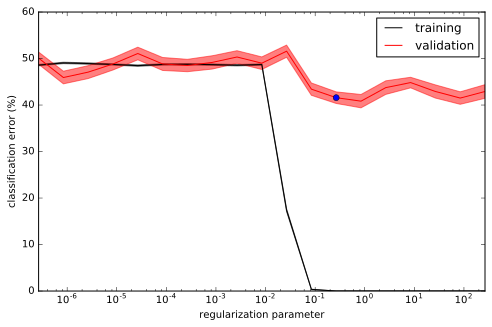

In [10]:
##%%%%%% plot coss-validation results
plt.figure('cross validation')

plt.fill_between(cvect, meanPerClassErrorTrain-semPerClassErrorTrain, meanPerClassErrorTrain+ semPerClassErrorTrain, alpha=0.5, edgecolor='k', facecolor='k')
plt.fill_between(cvect, meanPerClassErrorTest-semPerClassErrorTest, meanPerClassErrorTest+ semPerClassErrorTest, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(cvect, meanPerClassErrorTrain, 'k', label = 'training')
plt.plot(cvect, meanPerClassErrorTest, 'r', label = 'validation')
plt.plot(cvect[cvect==cbest], meanPerClassErrorTest[cvect==cbest], 'bo')
plt.xlim([cvect[1], cvect[-1]])
plt.xscale('log')
plt.xlabel('regularization parameter')
plt.ylabel('classification error (%)')
plt.legend()

## Train the best SVM model

0.0


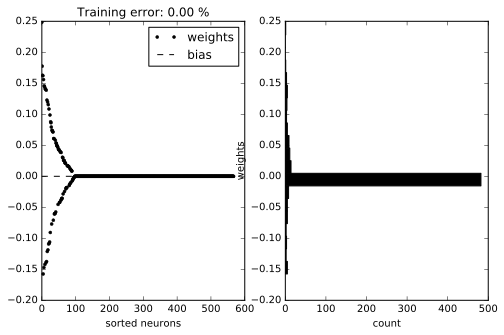

In [11]:
if regType == 'l1':
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l1', dual=False)
elif regType == 'l2':
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l2', dual=True)

linear_svm.fit(X, Y)
    
w = np.squeeze(linear_svm.coef_);
b = linear_svm.intercept_;

plt.figure()
plt.subplot(1,2,1)
plt.plot(w[np.argsort(abs(w))[::-1]], 'k.', label = 'weights')
plt.plot(np.ones(len(w))*b, 'k--', label = 'bias')
plt.xlabel('sorted neurons')
plt.legend()
plt.title(('Training error: %.2f %%' %(abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100)))
print abs(((np.dot(X,w)+b)>0).astype('float')-Y.astype('float')).sum()/len(Y)*100 # this is the prediction formula
plt.subplot(1,2,2)
plt.hist(w, 20,orientation='horizontal', color = 'k')
plt.ylabel('weights')
plt.xlabel('count')


## Null distribution using shuffles


In [12]:
numShuffles = 1000
summary_data = [];
summary_shfl = [];
perClassErrorTrain_data = [];
perClassErrorTest_data = []
perClassErrorTrain_shfl = [];
perClassErrorTest_shfl = [];
w_data = []
b_data = []
w_shfl = []
b_shfl = []
permIxsList = [];
for i in range(numShuffles):
    permIxs = rng.permutation(numTrials);
    permIxsList.append(permIxs);
    if regType == 'l1':
        summary_data.append(crossValidateModel(X, Y, linearSVM, kfold = kfold, l1 = cbest))
        summary_shfl.append(crossValidateModel(X, Y[permIxs], linearSVM, kfold = kfold, l1 = cbest))
    elif regType == 'l2':
        summary_data.append(crossValidateModel(X, Y, linearSVM, kfold = kfold, l2 = cbest))
        summary_shfl.append(crossValidateModel(X, Y[permIxs], linearSVM, kfold = kfold, l2 = cbest))
        
    perClassErrorTrain_data.append(summary_data[i].perClassErrorTrain);
    perClassErrorTest_data.append(summary_data[i].perClassErrorTest);
    w_data.append(np.squeeze(summary_data[i].model.coef_));
    b_data.append(summary_data[i].model.intercept_);
        
    perClassErrorTrain_shfl.append(summary_shfl[i].perClassErrorTrain);
    perClassErrorTest_shfl.append(summary_shfl[i].perClassErrorTest);
    w_shfl.append(np.squeeze(summary_shfl[i].model.coef_));
    b_shfl.append(summary_shfl[i].model.intercept_);



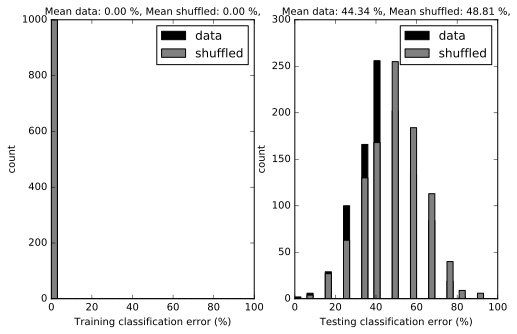

In [13]:
binEvery = 3; # bin width
plt.figure()
plt.subplot(1,2,1)
plt.hist(perClassErrorTrain_data, np.arange(0,100,binEvery), color = 'k', label = 'data');
plt.hist(perClassErrorTrain_shfl, np.arange(0,100,binEvery), color = [0.5, 0.5, 0.5], label = 'shuffled');
plt.xlabel('Training classification error (%)')
plt.ylabel('count')
plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%,' %(np.mean(perClassErrorTrain_data), np.mean(perClassErrorTrain_shfl)), fontsize = 10)
plt.legend()

plt.subplot(1,2,2)
plt.hist(perClassErrorTest_data, np.arange(0,100,binEvery), color = 'k', label = 'data');
plt.hist(perClassErrorTest_shfl, np.arange(0,100,binEvery), color = [0.5, 0.5, 0.5], label = 'shuffled');
plt.legend()
plt.xlabel('Testing classification error (%)')
plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%,' %(np.mean(perClassErrorTest_data), np.mean(perClassErrorTest_shfl)), fontsize = 10)
plt.ylabel('count')

## Data projections

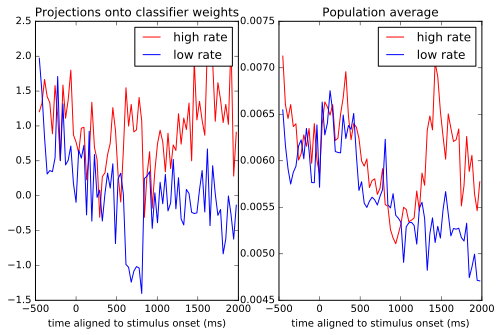

In [14]:
w_normalized = w/sci.linalg.norm(w);
XtN_w = np.dot(Xt_N, w_normalized);
Xt_w = np.reshape(XtN_w, (T,C), order='F');


plt.figure()
plt.subplot(1,2,1)
plt.plot(time_aligned, np.mean(Xt_w[:, Y>0],  axis = 1), 'r', label = 'high rate')
plt.plot(time_aligned, np.mean(Xt_w[:, Y<1],  axis = 1), 'b', label = 'low rate')
plt.xlabel('time aligned to stimulus onset (ms)')
plt.title('Projections onto classifier weights')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time_aligned, np.mean(Xt[:, :, Y>0],  axis = (1, 2)), 'r', label = 'high rate')
plt.plot(time_aligned, np.mean(Xt[:, :, Y<1],  axis = (1, 2)), 'b', label = 'low rate')
plt.xlabel('time aligned to stimulus onset (ms)')
plt.title('Population average')
plt.legend()


## Classification error per time

In [18]:
perClassEr_t = [];
for t in range(T):
    perClassEr_t.append(abs(linear_svm.predict(np.squeeze(Xt[t, :, :]).T)-Y).mean()*100)

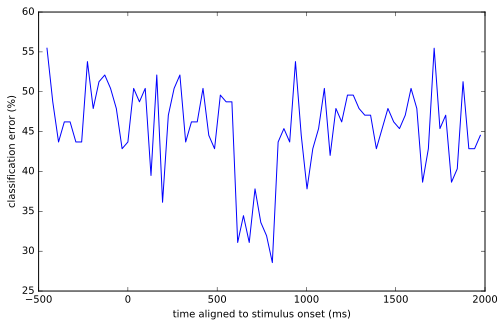

In [19]:
plt.figure()
plt.plot(time_aligned, perClassEr_t)
plt.xlabel('time aligned to stimulus onset (ms)')
plt.ylabel('classification error (%)')